In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from matplotlib import pyplot
sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from keras.layers import Dense, Dropout
from keras.models import Sequential
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.width', 2000)
from keras.optimizers import SGD
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion

import keras
from tensorflow.python import debug as tf_debug
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import import_ipynb
from Helpers import *
from PandasFeatureUnion import PandasFeatureUnion

Using TensorFlow backend.


importing Jupyter notebook from Helpers.ipynb
importing Jupyter notebook from PandasFeatureUnion.ipynb


/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv', index_col='Id')
test = pd.read_csv('test.csv',index_col='Id')
test_ids = test.index
y_train = np.log(train['SalePrice'])
np.random.seed(1)
random.seed(1)
total_bath= lambda x: x.FullBath+x.HalfBath*0.5 +x.BsmtHalfBath*0.5+x.BsmtFullBath


bath_columns = ['FullBath','HalfBath','BsmtHalfBath', 'BsmtFullBath']
bath_pipeline = Pipeline([
    ('SelectBathColumns',  ColumnSelector(columns=bath_columns)),
    ('fillNaAsZero', FillNA(columns=bath_columns, fill_value=0)),
    ('combine', ApplyTransformer(fn=total_bath, name='Bath')),
  #  ('drop',DropColumns(columns=bath_columns))
]) 
  

important_columns = [
    'GrLivArea', 'YearBuilt', 'OverallQual','MSSubClass',
    'Neighborhood', 'SaleType', 'SaleCondition',
    'BldgType','LotFrontage','GarageCars',
    'PoolQC', 'BsmtQual','ExterQual', 'KitchenQual',
    'MasVnrType', 'LotArea',  '1stFlrSF', 'HouseStyle'
]
# No improovement
# 'BldgType' 

cs = ColumnSelector(columns=important_columns)

scdt = DummiesTransformer(column='MSSubClass', keys=[ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 150, 160, 180, 190])
oqdt = DummiesTransformer(column='OverallQual', keys=range(1,11))
neigbTrans = DummiesTransformer(column='Neighborhood', keys=["Blmngtn", "Blueste", "BrDale", "BrkSide", "ClearCr", "CollgCr", "Crawfor", "Edwards", "Gilbert", "IDOTRR", "MeadowV", "Mitchel", "Names", "NoRidge", "NPkVill", "NridgHt", "NWAmes", "OldTown", "SWISU", "Sawyer", "SawyerW", "Somerst", "StoneBr", "Timber", "Veenker"])
bdTypeTrans= DummiesTransformer(column='BldgType', keys=['1Fam' ,'TwnhsE', 'Twnhs', 'Duplex', '2fmCon'])
saleTypeTrans= DummiesTransformer(column='SaleType', keys=["WD","CWD","VWD","New","COD","Con","ConLw","ConLI","ConLD","Oth"])
bsmtQualTrans = DummiesTransformer(column='BsmtQual', keys=['Ex','Gd','TA','Fa','Po','None'])
extQualTrans = DummiesTransformer(column='ExterQual', keys=['Ex','Gd','TA','Fa','Po','None'])
kitQualTrans = DummiesTransformer(column='KitchenQual', keys=['Ex','Gd','TA','Fa','Po','None'])
saleCondTrans = DummiesTransformer(column='SaleCondition', keys=['Normal', 'Abnorml',
                                                                'AdjLand','Alloca', 
                                                                 'Family', 'Partial'])
masVnrTypeTrans = DummiesTransformer(column='MasVnrType', keys=['BrkCmn', 'BrkFace', 
                                                                'CBlock','None', 'Stone'])
lotConfigTrans = DummiesTransformer(column='LotConfig', keys=['Inside', 'Corner', 'CulDSac',
                                                             'FR2', 'FR3'])
houseStyleTrans = DummiesTransformer(column='HouseStyle', keys=['1Story','1.5Fin','1.5Unf',
                                                               '2Story','2.5Fin','2.5Unf',
                                                               'SFoyer','SLvl'])

core_pipeline = Pipeline(
    [('SelectColumns', cs),
     ('DummiesMSSubClass', scdt),
     ('OverallQual', oqdt),
     ('DummiesNeighborhood', neigbTrans),
     ('DummiesSaleType', saleTypeTrans),
     ('DummiesBldgType',bdTypeTrans),
     ('fillNaAsZero', FillNA(columns=['LotFrontage','GarageCars'], fill_value=0)),
     ('fillNaAsNone', FillNA(columns=['BsmtQual','ExterQual','KitchenQual', 
                                     'SaleCondition','MasVnrType'], fill_value='None')),
     ('LogLotFrontage', ApplyTransformer(fn=lambda x:np.log1p(x.LotFrontage), name='LotFrontage')),
     ('LogGrLivArea', ApplyTransformer(fn=lambda x:np.log1p(x.GrLivArea), name='GrLivArea')),
     ('Log1stFlrSF', ApplyTransformer(fn=lambda x:np.log1p(x['1stFlrSF']), name='1stFlrSF')),
     ('PoolQC_Exists', ApplyTransformer(fn=lambda x:0 if (pd.isnull(x['PoolQC'])) else 1, name='PoolQC')),
     ('BsmtQualTrans', bsmtQualTrans),
     ('ExtQualTrans', extQualTrans),
     ('kitQualTrans', kitQualTrans),
     ('saleCondTrans', saleCondTrans),
      ('houseStyletrans', houseStyleTrans),
     ('masVnrTypeTrans',masVnrTypeTrans)
    ])

pp = PandasFeatureUnion([
    ('bath',bath_pipeline),
    ('core', core_pipeline)], n_jobs=None)

X_train = pp.fit_transform(train)
X_test = pp.transform(test)
 
 

/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/drmegavolt/miniconda3/envs/home_iowa/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [3]:
# define model
# cc=keras.constraints.MinMaxNorm(min_value=0.0, max_value=2.0, rate=1, axis=0)
model = Sequential()
input_layer = Dense(20, 
#                     kernel_constraint=cc,
#                     kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#                     bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
                    input_dim=len(X_train.columns), 
                    activation='relu', 
                    kernel_initializer='normal') 
model.add(input_layer)

model.add(Dense(100, activation='relu', kernel_initializer='normal') )
# model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='linear'))

optimizer = keras.optimizers.SGD(lr=0.001) #Adam(lr=0.0015);
# compile model
model.compile(loss='mean_squared_error', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.
Restoring model weights from the end of the best epoch
Epoch 01232: early stopping
Train Error: 0.127, Test Error: 0.151


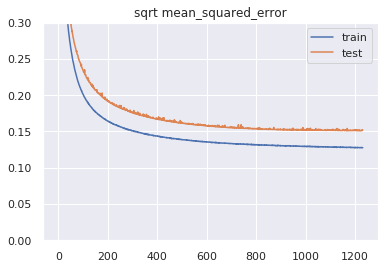

In [4]:

trainX, testX, trainy, testy = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.2, 
                                                    random_state=1)

trainX_ids = trainX.index
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(trainX)
trainX= scaler.transform(trainX)
testX= scaler.transform(testX)
testData = X_test
X_test=scaler.transform(X_test)
# fit model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, 
                                           patience=60, verbose=1, mode='auto', 
                                           baseline=None, restore_best_weights=True)
tb_callback =keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, 
                                         batch_size=32, write_graph=True, 
                                         write_grads=True, write_images=True,
                                         embeddings_freq=0, embeddings_layer_names=None,
                                         embeddings_metadata=None, embeddings_data=None,
                                         update_freq='epoch')
history = model.fit(trainX, trainy, validation_data=(testX, testy), 
                    epochs=3000, verbose=0, batch_size=32, callbacks=[early_stop, tb_callback])

drawTFModel(history, model, trainX, trainy, testX, testy)

In [5]:
result = model.predict(X_test)
dfR = pd.DataFrame(test_ids,columns=['Id'])
dfR['SalePrice']=np.exp(result)
dfR.to_csv('predictions.csv',index = None, header=True)

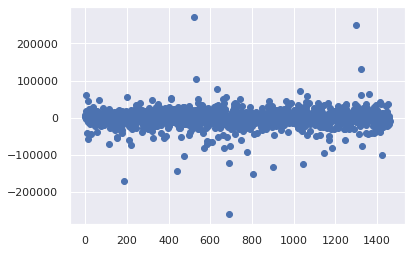

Int64Index([ 922,  521,  402,  281, 1402,  132,  809, 1250, 1084,  614,
            ...
             750,  130,  145,  961,  848,  716,  906, 1097,  236, 1062], dtype='int64', name='Id', length=1168)
Int64Index([ 922,  521,  402,  281, 1402,  132,  809, 1250, 1084,  614,
            ...
             750,  130,  145,  961,  848,  716,  906, 1097,  236, 1062], dtype='int64', name='Id', length=1168)
Int64Index([474, 186, 899, 689, 692, 804, 441, 1047], dtype='int64', name='Id')
         Predicted      Real         Delta
Id                                        
474   337455.81250  440000.0 -102544.18750
186   303353.46875  475000.0 -171646.53125
899   478470.15625  611657.0 -133186.84375
689   271031.34375  392000.0 -120968.65625
692   494947.25000  755000.0 -260052.75000
804   431786.71875  582933.0 -151146.28125
441   410947.56250  555000.0 -144052.43750
1047  432410.59375  556581.0 -124170.40625


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
474,20,RL,110.0,14977,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,BrkFace,304.0,Gd,TA,PConc,Ex,TA,Gd,GLQ,1350,Unf,0,626,1976,GasA,Ex,Y,SBrkr,1976,0,0,1976,1,0,2,0,2,1,Gd,7,Typ,1,Ex,Attchd,2006.0,RFn,3,908,TA,TA,Y,250,63,0,0,0,0,NaN,NaN,NaN,0,7,2007,New,Partial,440000
186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,2.5Fin,10,9,1892,1993,Gable,WdShngl,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,BrkTil,TA,TA,Mn,Unf,0,Unf,0,1107,1107,GasA,Ex,Y,SBrkr,1518,1518,572,3608,0,0,2,1,4,1,Ex,12,Typ,2,TA,Detchd,1993.0,Unf,3,840,Ex,TA,Y,0,260,0,0,410,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000
899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188,Unf,0,142,2330,GasA,Ex,Y,SBrkr,2364,0,0,2364,1,0,2,1,2,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3,820,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
689,20,RL,60.0,8089,Pave,NaN,Reg,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,6,2007,2007,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,945,Unf,0,474,1419,GasA,Ex,Y,SBrkr,1419,0,0,1419,1,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2007.0,RFn,2,567,TA,TA,Y,140,0,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,392000
692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1734,1734,GasA,Ex,Y,SBrkr,1734,1088,0,2822,0,0,3,1,4,1,Ex,12,Typ,1,Gd,BuiltIn,2009.0,RFn,3,1020,TA,TA,Y,52,170,0,0,192,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1767,ALQ,539,788,3094,GasA,Ex,Y,SBrkr,2402,0,0,2402,1,0,2,0,2,1,Ex,10,Typ,2,Gd,Attchd,2008.0,Fin,3,672,TA,TA,Y,0,72,0,0,170,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,CemntBd,CmentBd,Stone,208.0,Gd,TA,PConc,Ex,TA,Av,GLQ,240,Unf,0,1752,1992,GasA,Ex,Y,SBrkr,1992,876,0,2868,0,0,3,1,4,1,Ex,11,Typ,1,Gd,BuiltIn,2005.0,Fin,3,716,TA,TA,Y,214,108,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,Partial,556581


In [6]:
tt = pd.DataFrame(trainX_ids,columns=['Id']).set_index('Id')
trainedPrice = model.predict(trainX)
tt['Predicted']=np.exp(trainedPrice)
tt['Real']=np.exp(trainy)
tt['Delta'] = tt.Predicted - tt.Real
plt.scatter(tt.index, tt.Delta)
plt.show()

print(tt.index)
print(trainX_ids)

problematicIDs = tt[tt.Delta <-100000]
print(problematicIDs.index)

print(tt.loc[problematicIDs.index, :])
train.loc[problematicIDs.index, :]

In [7]:
# print(model.get_weights())

In [8]:
df=train

In [9]:
!rm -rf logs

In [10]:
pd.DataFrame(X_test, columns=testData.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
FullBath,1459.0,0.523646,0.185063,0.000000,0.333333,0.666667,0.666667,1.333333
HalfBath,1459.0,0.188828,0.251508,0.000000,0.000000,0.000000,0.500000,1.000000
BsmtHalfBath,1459.0,0.032557,0.126153,0.000000,0.000000,0.000000,0.000000,1.000000
BsmtFullBath,1459.0,0.144620,0.176842,0.000000,0.000000,0.000000,0.333333,1.000000
Bath,1459.0,0.245236,0.166367,0.000000,0.100000,0.200000,0.400000,1.200000
GrLivArea,1459.0,0.510034,0.111867,0.069807,0.426911,0.514651,0.579705,0.963896
YearBuilt,1459.0,0.719984,0.220218,0.050725,0.586957,0.731884,0.934783,1.000000
LotFrontage,1459.0,0.614727,0.269994,0.000000,0.662098,0.723360,0.759984,0.922411
GarageCars,1459.0,0.441227,0.194264,0.000000,0.250000,0.500000,0.500000,1.250000
PoolQC,1459.0,0.002056,0.045314,0.000000,0.000000,0.000000,0.000000,1.000000


In [11]:
test_ids

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919], dtype='int64', name='Id', length=1459)

In [12]:
testData.index

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919], dtype='int64', name='Id', length=1459)

In [13]:
testData.loc[2577,:]

FullBath                    2.000000
HalfBath                    0.000000
BsmtHalfBath                0.000000
BsmtFullBath                0.000000
Bath                        2.000000
GrLivArea                   7.511525
YearBuilt                1923.000000
LotFrontage                 3.931826
GarageCars                  0.000000
PoolQC                      0.000000
LotArea                  9060.000000
1stFlrSF                    6.849066
MSSubClass_20               0.000000
MSSubClass_30               0.000000
MSSubClass_40               0.000000
MSSubClass_45               0.000000
MSSubClass_50               0.000000
MSSubClass_60               0.000000
MSSubClass_70               1.000000
MSSubClass_75               0.000000
MSSubClass_80               0.000000
MSSubClass_85               0.000000
MSSubClass_90               0.000000
MSSubClass_120              0.000000
MSSubClass_150              0.000000
MSSubClass_160              0.000000
MSSubClass_180              0.000000
M

In [14]:
n=lambda x: (1 if (pd.isnull(x)) else 0)

In [15]:
n(np.nan)

1

In [16]:
n(55)

0

In [17]:
n(None)

1

In [18]:
pd.isnull('sss')

False